
<div class="container">

<ul style="list-style-type: none;margin: 0;padding: 0;overflow: hidden;background-color: #333;">
  <li style="float: left;"><a class="active" style="display: block;color: white;text-align: center;padding: 14px 16px;text-decoration: none;background-color: #4CAF50;">Navigation</a></li>
  <li style="float: left;"><a href="#hist" style="display: block;color: #dfe6e9;text-align: center;padding: 14px 16px;text-decoration: none;">BoW Histograms</a></li>
  <li style="float: left;"><a href="#expk" style="display: block;color: #dfe6e9;text-align: center;padding: 14px 16px;text-decoration: none;">Experiment on k</a></li>
  <li style="float: left;"><a href="#expc" style="display: block;color: #dfe6e9;text-align: center;padding: 14px 16px;text-decoration: none;">Experiment on C</a></li>
  <li style="float: left;"><a href="#eval" style="display: block;color: #dfe6e9;text-align: center;padding: 14px 16px;text-decoration: none;">Evaluation</a></li>
  <li style="float: left;"><a href="#competition" style="display: block;color: #dfe6e9;text-align: center;padding: 14px 16px;text-decoration: none;">Competition</a></li>
</ul>
<div class="jumbotron">
    <h1 style="font-weight: bold; font-size: 2em;">Computer Vision: Homework 5</h1>      
    <p style="margin-bottom: 1em; font-family: sans-serif; text-align: justify;">
        Zicong Fan, 11205168;
        CS ID: fan
    </p>
</div>    


</div>

In [1]:
import numpy as np
import os
import glob

import itertools
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

np.random.seed(2)

## Non-modified Routines

In [2]:
def sample_images(ds_path, n_sample):
    """ Sample images from the training/testing dataset.

    Parameters
    ----------
    ds_path: path to the training/testing dataset.
             e.g., sift/train or sift/test
    n_sample: the number of images you want to sample from the dataset.
              if None, use the entire dataset. 
    
    Returns
    -------
    image_paths: a (n_sample, 1) array that contains the paths to the descriptors. 
    """
    # Grab a list of paths that matches the pathname
    files = glob.glob(os.path.join(ds_path, "*", "*.txt"))
    n_files = len(files)

    if n_sample == None:
        n_sample = n_files

    # Randomly sample from the training/testing dataset
    # Depending on the purpose, we might not need to use the entire dataset
    idx = np.random.choice(n_files, size=n_sample, replace=False)
    image_paths = np.asarray(files)[idx]
 
    # Get class labels
    classes = glob.glob(os.path.join(ds_path, "*"))
    labels = np.zeros(n_sample)

    for i, path in enumerate(image_paths):
        folder, fn = os.path.split(path)
        labels[i] = np.argwhere(np.core.defchararray.equal(classes, folder))[0,0]

    return image_paths, labels


## Self-written or modified routines
### Feature Extraction Routines

In [3]:
def build_vocabulary(image_paths, vocab_size):
    """ Sample SIFT descriptors, cluster them using k-means, and return the fitted k-means model.
    NOTE: We don't necessarily need to use the entire training dataset. You can use the function
    sample_images() to sample a subset of images, and pass them into this function.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    vocab_size: the number of clusters desired.
    
    Returns
    -------
    kmeans: the fitted k-means clustering model.
    """
    n_image = len(image_paths)

    # Since want to sample tens of thousands of SIFT descriptors from different images, we
    # calculate the number of SIFT descriptors we need to sample from each image.
    n_each = int(np.ceil(20000 / n_image))  # You can adjust 10000 if more is desired
    
    # Initialize an array of features, which will store the sampled descriptors
    features = np.zeros((n_image * n_each, 128))
    
    start_i = 0 # current index to insert new descriptors into 'features'
    
    # TODO: Randomly sample n_each features from descriptors, and store them in features
    for i, path in enumerate(image_paths):
        # Load SIFT features from path
        descriptors = np.loadtxt(path, delimiter=',',dtype=float)
        
        # number of descriptors in this image
        max_len = descriptors.shape[0]
        
        
        if n_each <= max_len: 
            # choose `n_each` descriptors out of `max_len` descriptors with no replacement. 
            ind = np.random.choice(max_len, n_each, replace=False) 
            features[start_i:(start_i+n_each)] = descriptors[ind]
            
            # update the starting index of the next iteration
            start_i += n_each
        else: 
            # add all descriptors (because we don't have `n_each` amount)
            features[start_i:(start_i+descriptors.shape[0])] = descriptors
            
            # update the starting index of the next iteration
            start_i += descriptors.shape[0]

    # `start_i` also denotes the number of added descriptor
    features = features[:start_i] # remove remaining unused space
        
    
    # TODO: pefrom k-means clustering to cluster sampled SIFT features into vocab_size regions.
    kmeans = KMeans(n_clusters=vocab_size, random_state=0, max_iter=10000).fit(features)
    
    return kmeans

def get_bags_of_sifts(image_paths, kmeans):
    """ Represent each image as bags of SIFT features histogram.

    Parameters
    ----------
    image_paths: an (n_image, 1) array of image paths.
    kmeans: k-means clustering model with vocab_size centroids.

    Returns
    -------
    image_feats: an (n_image, vocab_size) matrix, where each row is a histogram.
    """
    n_image = len(image_paths)
    vocab_size = kmeans.cluster_centers_.shape[0]

    image_feats = np.zeros((n_image, vocab_size))

    for i, path in enumerate(image_paths):
        # Load SIFT descriptors
        descriptors = np.loadtxt(path, delimiter=',',dtype=float)
        
        # TODO: Assign each descriptor to the closest cluster center
        labels = kmeans.predict(descriptors)
        
        # TODO: Build a histogram normalized by the number of descriptors
        hist = np.zeros(kmeans.n_clusters)
        # count the occurance of assigned clustered for descriptors in an image. 
        for label in labels: 
            hist[label] = hist[label] + 1.0 # float for division later
        
        # normalize histogram to sum to 1
        hist = hist/descriptors.shape[0]
        
        # sanity check
        assert abs(sum(hist)-1.0) < 1e-9, "Histogram should sum to 1."
        
        # store the histogram for this image
        image_feats[i] = hist

    return image_feats

print('Getting paths and labels for all train and test data\n')
train_image_paths, train_labels = sample_images("sift/train", n_sample=1500)
test_image_paths, test_labels = sample_images("sift/test", n_sample=500)


print('Extracting SIFT features\n')
kmeans = build_vocabulary(train_image_paths, vocab_size=200)

# get images in BoW forms (200 dimensions to represent each image)
train_image_feats = get_bags_of_sifts(train_image_paths, kmeans)
test_image_feats = get_bags_of_sifts(test_image_paths, kmeans)

Getting paths and labels for all train and test data

Extracting SIFT features



### Evaluation Routines

In [32]:
# get the accuracy of classification (between 0 and 1)
def getAccuracy(y_true, y_pred): 
    return 1.0*sum(y_true == y_pred)/y_true.shape[0]

# get the name strings of each class
def getClassNames(): 
    
    # get names from train and test classes
    classes = glob.glob(os.path.join("sift/train", "*"))
    
    # remove prefix, e.g. 'sift/train/Forest' becomes 'Forest'
    L = [s.replace('sift/train/', '') for s in classes]
    classes = glob.glob(os.path.join("sift/test", "*"))
    R = [s.replace('sift/test/', '') for s in classes]
    
    # the label names for train and test data should the same
    # just a sanity check
    assert L == R, 'label names or order do not match'
    return L

# This function plots the confusion matrix with color. 
# It is provided by the sklearn website. 
# According to the professor, we are allowed to use the sklearn's confusion matrix util. 
# Cite: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
# evaluate performance of classifications
def evaluate(y_true, y_pred): 
    # compute the confusion matrix
    # Professor says we can use the confusion matrix library. 
    # https://piazza.com/class/jkx37y3y5xj2e8?cid=283
    cm = confusion_matrix(y_true, y_pred);
    
    # get names of all labels
    classes = getClassNames() 
    
    # visualize the matrix in color
    plot_confusion_matrix(cm, classes)
    
    # print accuracy of classification
    print("The accuracy is %.4f"%(getAccuracy(y_true, y_pred)))

### Plot histogram routines

In [5]:
def plot_average_hist(image_paths_of_cat, kmeans): 
    # plot title with category name
    plt.title(image_paths_of_cat)
    
    # agument the path for data reading
    prefix = "sift/train/"
    postfix = "/*"
    image_paths_of_cat = prefix + image_paths_of_cat + postfix
    
    # extract all images paths from one category
    paths = glob.glob(os.path.join(image_paths_of_cat))
    
    # extract SIFT features of images
    image_feats = get_bags_of_sifts(paths, kmeans)
    
    # compute average of each category
    mean_hist = np.mean(image_feats, axis=0)
    mean_hist = mean_hist / mean_hist.sum() ## renormalize
    
    # plot histogram for 1 category
    plt.bar(range(kmeans.n_clusters), mean_hist)
    plt.ylim((0, 0.04)) # use the same scale to plot
    plt.xlabel("Cluster ids")
    plt.ylabel("Fraction")
    plt.show()

<div id="hist"></div>

## Plot average histograms

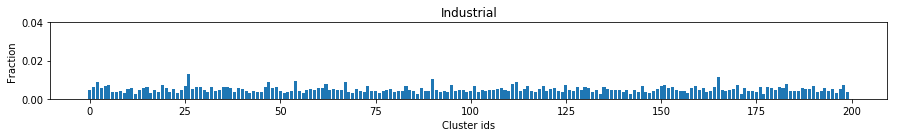

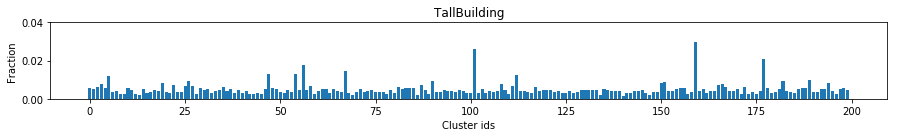

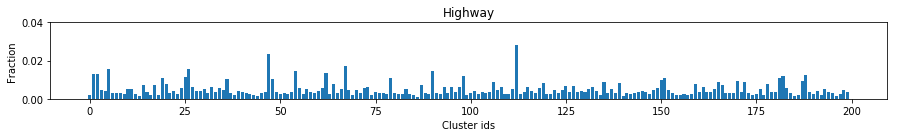

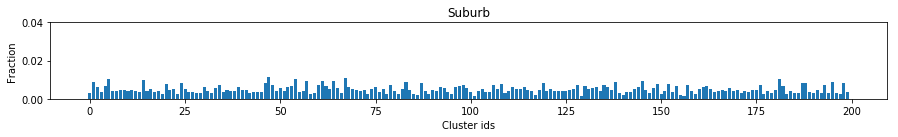

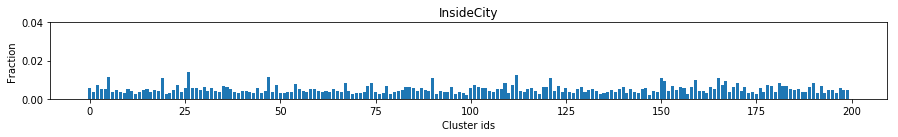

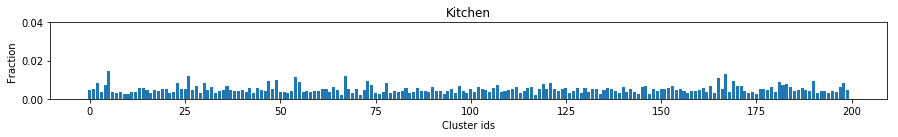

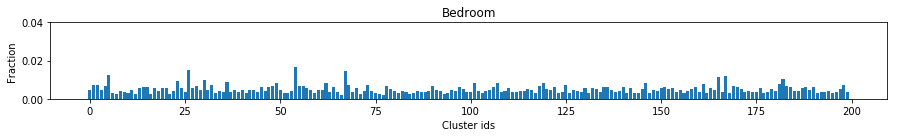

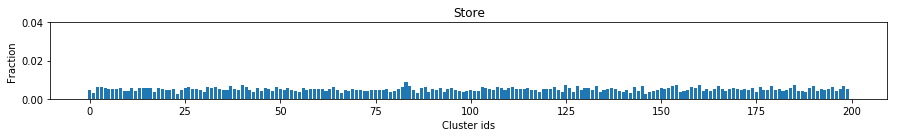

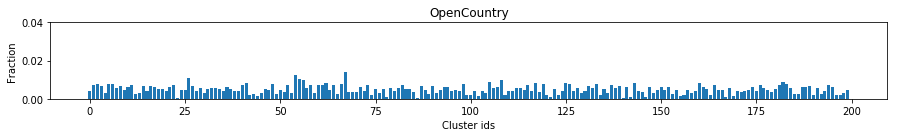

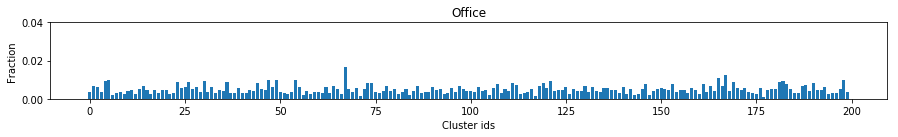

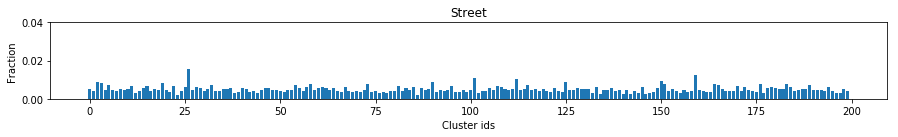

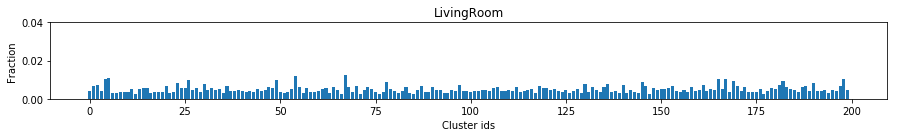

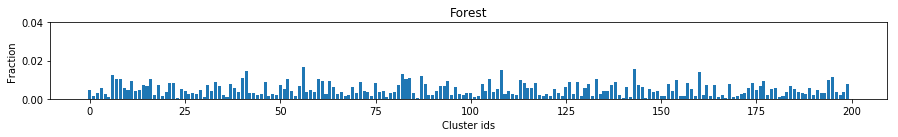

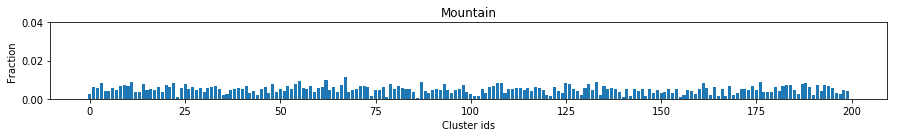

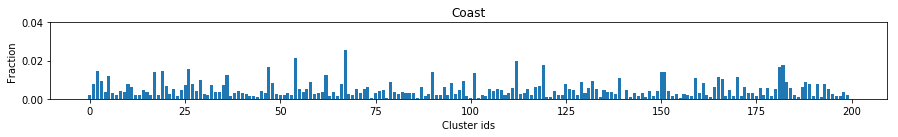

In [6]:
categories = getClassNames()
for i, c in enumerate(categories): 
    plt.figure(figsize=(15,25)) # figure size
    plt.subplot(15, 1, i+1) # plot in the same figure
    plot_average_hist(c, kmeans) # plot average histogram

**How different are the histograms from different classes**: 

For most classes, the histograms are quite different from each other. For example, histograms for some classes are more uniform (such as `industrial`, `suburb` and `store`) while the others have many significant peaks in its histogram (such as `coast`,  `tallBuilding`, and `highway`). In particular, `store ` tends to have shorter histogram bars and most bars have similar lengths while `forest` has very long bars and its bars have very different lengths. The confusion matrix below confirms this hypothesis (both classifiers barely misclassify the two classes).

**Which classes you may believe to be hardest to separate**: 

The histograms of `openCountry` and `mountain` look very similar. Therefore, this pair is the hardest to separate. In detail, both `openCountry` and `mountain` have a "local min" in histogram at around cluster `100`, a very similar shape in the interval `[0, 25]`, and a small "bell shape" in the interval `[100, 125]`. In fact, it makes sense, because in real life, countryside and moutain have very similar appeareance (such as grass and trees). Additionally, the confusion matrix in the below, it confirms the hypothesis.


## ML Models

Since the instruction only requires showing how to pick `n_neigbors` (`k`) and `C`, and there are exponential amount of hyper-parameter combination, to make this report concise, I only provide the experiment on choosing the hyperparameter `n_neigbors` and `C`. The experiemnts are available in the section `Experiment with k for KNN` and `Experiment with C for SVM`.

In [7]:
def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):    
    # use cosine similarity as distance metric
    # use 12 neigbours to vote
    # weight the votes of its k-neigbours according to distance to the input feature
    knn = KNeighborsClassifier(metric="cosine", weights="distance", n_neighbors=12)
    
    # fit and predict 
    knn.fit(train_image_feats, train_labels)
    predicted_labels = knn.predict(test_image_feats)
    return predicted_labels

def svm_classify(train_image_feats, train_labels, test_image_feats):
    # the documentation suggest using 'dual=False' when there are lots of data. 
    svm = LinearSVC(random_state=0, tol=1e-6, dual=False, loss='squared_hinge', C=24)
    
    # fit and predict
    svm.fit(train_image_feats, train_labels)
    predicted_labels = svm.predict(test_image_feats)
    return predicted_labels

### Evaluate

In [8]:
print('Using nearest neighbor classifier to predict test set categories\n')
pred_labels_knn = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)
  

print('Using support vector machine to predict test set categories\n')
pred_labels_svm = svm_classify(train_image_feats, train_labels, test_image_feats)

Using nearest neighbor classifier to predict test set categories

Using support vector machine to predict test set categories



<div id="expk"></div>

### Experiment with `k` for KNN
The following code splits train data into train and validation set to experiment on different `k`. From the result, we could see that, if `k` is too small, the accuracy is limited to `0.34`. However, as `k` increases, the accuracy increases as well. The accuracy reaches the maximum when `k=12` and the accuracy starts to decrease. 

It makes sense because the smaller `k`, we have a simpler KNN model, which implies `underfitting`; with a bigger `k`, it starts to `overfit` and thus decrease in test performance.

In [9]:
def knn_experiment_k(X_train, y_train, X_test, y_test, k):
    # linesearch on k while keep the other hyper-parameter fixed
    knn = KNeighborsClassifier(metric="cosine", weights="distance", n_neighbors=k)
    knn.fit(X_train, y_train)
    predicted_labels = knn.predict(X_test)
    accuracy = 1.0*sum(y_test == predicted_labels)/y_test.shape[0]
    print("Accuracy of knn (k = %d) is %.2f" %(k, accuracy))

In [10]:
from sklearn.model_selection import train_test_split

# split the training data randomly to train and validation set (80% and 20%)
# random_state: the seed used for the randomness
X_train, X_val, y_train, y_val = train_test_split(train_image_feats, train_labels, test_size=0.2, random_state=1)

# linesearch for the best k
for k in range(1, 100, 1): 
    knn_experiment_k(X_train, y_train, X_val, y_val, k)

Accuracy of knn (k = 1) is 0.34
Accuracy of knn (k = 2) is 0.34
Accuracy of knn (k = 3) is 0.36
Accuracy of knn (k = 4) is 0.38
Accuracy of knn (k = 5) is 0.40
Accuracy of knn (k = 6) is 0.41
Accuracy of knn (k = 7) is 0.40
Accuracy of knn (k = 8) is 0.42
Accuracy of knn (k = 9) is 0.41
Accuracy of knn (k = 10) is 0.41
Accuracy of knn (k = 11) is 0.41
Accuracy of knn (k = 12) is 0.43
Accuracy of knn (k = 13) is 0.41
Accuracy of knn (k = 14) is 0.41
Accuracy of knn (k = 15) is 0.40
Accuracy of knn (k = 16) is 0.40
Accuracy of knn (k = 17) is 0.41
Accuracy of knn (k = 18) is 0.40
Accuracy of knn (k = 19) is 0.40
Accuracy of knn (k = 20) is 0.41
Accuracy of knn (k = 21) is 0.41
Accuracy of knn (k = 22) is 0.42
Accuracy of knn (k = 23) is 0.41
Accuracy of knn (k = 24) is 0.40
Accuracy of knn (k = 25) is 0.39
Accuracy of knn (k = 26) is 0.40
Accuracy of knn (k = 27) is 0.40
Accuracy of knn (k = 28) is 0.40
Accuracy of knn (k = 29) is 0.39
Accuracy of knn (k = 30) is 0.40
Accuracy of knn (k 

<div id="expc"></div>

### Experiment with `C` for SVM

In [11]:
def svm_experiment_c(X_train, y_train, X_test, y_test, c):
    # line search on C but keep the other hyper-parameters fixed
    svm = LinearSVC(random_state=0, tol=1e-5, dual=False, loss='squared_hinge', C=c)
    
    # fit and predict
    svm.fit(X_train, y_train)
    predicted_labels = svm.predict(X_test)
    accuracy = 1.0*sum(y_test == predicted_labels)/y_test.shape[0]
    
    # evaluate accuracy
    print("Accuracy of svm (c = %d) is %.2f" %(c, accuracy))

Doing a coarse search on the parameter `C`, we can see that the model performs the best when `C` is in the interval about `[1, 100]`. If `C` is too small (e.g. `C=1`), the model has limited accuracy; as `C` gets bigger, the accuracy increases. However, the accuracy starts to decrease when `C` is too big (`C=101`). It makes sense because if `C` is too big, we penalize the model too much on its regularity and thus lose performance. 

In [12]:
for c in range(1, 500, 25): 
    svm_experiment_c(X_train, y_train, X_val, y_val, c)

Accuracy of svm (c = 1) is 0.44
Accuracy of svm (c = 26) is 0.51
Accuracy of svm (c = 51) is 0.51
Accuracy of svm (c = 76) is 0.51
Accuracy of svm (c = 101) is 0.49
Accuracy of svm (c = 126) is 0.49
Accuracy of svm (c = 151) is 0.48
Accuracy of svm (c = 176) is 0.48
Accuracy of svm (c = 201) is 0.47
Accuracy of svm (c = 226) is 0.47
Accuracy of svm (c = 251) is 0.46
Accuracy of svm (c = 276) is 0.46
Accuracy of svm (c = 301) is 0.45
Accuracy of svm (c = 326) is 0.45
Accuracy of svm (c = 351) is 0.43
Accuracy of svm (c = 376) is 0.43
Accuracy of svm (c = 401) is 0.44
Accuracy of svm (c = 426) is 0.43
Accuracy of svm (c = 451) is 0.43
Accuracy of svm (c = 476) is 0.42


To find the best `C`, we then perform a fine search over the interval `[1, 100]`. We see that the interval `[21, 28]` gives the best accuracy. Thus, pick `C` around the center (`C=24`). 

In [13]:
for c in range(1, 101, 1): 
    svm_experiment_c(X_train, y_train, X_val, y_val, c)

Accuracy of svm (c = 1) is 0.44
Accuracy of svm (c = 2) is 0.48
Accuracy of svm (c = 3) is 0.49
Accuracy of svm (c = 4) is 0.50
Accuracy of svm (c = 5) is 0.50
Accuracy of svm (c = 6) is 0.50
Accuracy of svm (c = 7) is 0.51
Accuracy of svm (c = 8) is 0.50
Accuracy of svm (c = 9) is 0.50
Accuracy of svm (c = 10) is 0.50
Accuracy of svm (c = 11) is 0.50
Accuracy of svm (c = 12) is 0.50
Accuracy of svm (c = 13) is 0.50
Accuracy of svm (c = 14) is 0.50
Accuracy of svm (c = 15) is 0.50
Accuracy of svm (c = 16) is 0.50
Accuracy of svm (c = 17) is 0.50
Accuracy of svm (c = 18) is 0.50
Accuracy of svm (c = 19) is 0.50
Accuracy of svm (c = 20) is 0.50
Accuracy of svm (c = 21) is 0.51
Accuracy of svm (c = 22) is 0.51
Accuracy of svm (c = 23) is 0.51
Accuracy of svm (c = 24) is 0.51
Accuracy of svm (c = 25) is 0.51
Accuracy of svm (c = 26) is 0.51
Accuracy of svm (c = 27) is 0.51
Accuracy of svm (c = 28) is 0.51
Accuracy of svm (c = 29) is 0.50
Accuracy of svm (c = 30) is 0.50
Accuracy of svm (c 

<div id="eval"></div>

## Evaluation

### Evaluate on `Train Set`

According to `Leonid's` comment in this [post](https://piazza.com/class/jkx37y3y5xj2e8?cid=311), we do not need to report train errors. 


### Evaluate on `Test Set`

Summarize accuracy of models: 

| Model 	| KNN 	| LinearSVM 	|
|----------	|------	|-----------	|
| Accuracy 	| 0.39 	| 0.53 	|

#### KNN

Using nearest neighbor classifier to predict test set categories
The accuracy is 0.39


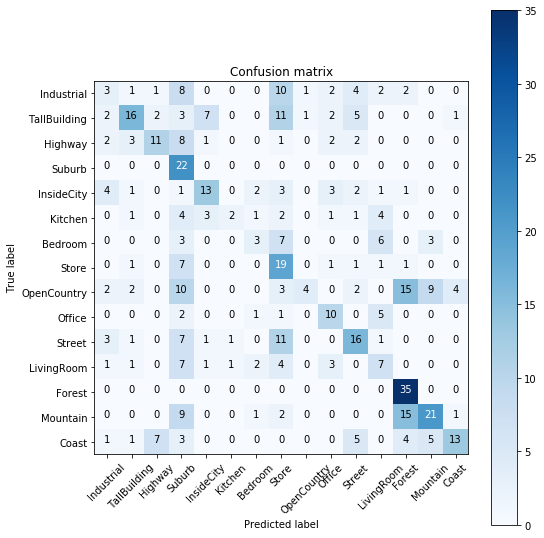

In [14]:
#TODO: YOU CODE nearest_neighbor_classify function from classifers.py
print('Using nearest neighbor classifier to predict test set categories')
pred_labels_knn = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)
plt.rcParams["figure.figsize"] = (8,8) # figure size
evaluate(test_labels, pred_labels_knn) # evaluate on test set

#### SVM

Using support vector machine to predict test set categories
The accuracy is 0.53


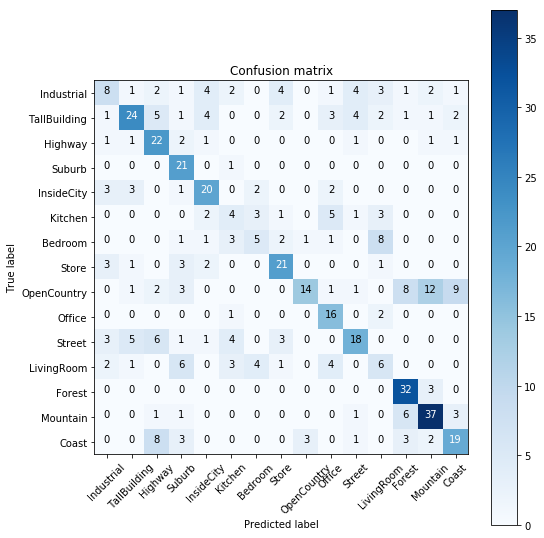

In [15]:
#TODO: YOU CODE svm_classify function from classifers.py
print('Using support vector machine to predict test set categories')
pred_labels_svm = svm_classify(train_image_feats, train_labels, test_image_feats)
plt.rcParams["figure.figsize"] = (8,8) # figure size
evaluate(test_labels, pred_labels_svm) # evaluate on test set

<div id="competition"> </div>

## Competition

> Note: To make the grading easier, I make the below competition code independent from the above code. Thus, the data are loaded again and shuffled. Thus, its accuracy cannot be compared to the models above. 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import KFold


import matplotlib.pyplot as plt
import math
import csv
import itertools

### Extract SIFT features with locations

The dataset provided by the course do not contain locations for descriptors. The following routines are for extracting the xy corrdinate and the 128 dimension descriptor. It runs on `Python2.7`. The script will create two kinds of files in the images folder: `*.shape` and `*.csv`. `*.shape` files stores the width and height of the image; `*.csv` files store the xy coordinate and 128-dim descriptor. 

The following SIFT feature extraction might take a few minutes. 

In [17]:
import cv2 as cv
def extract_images():
    sift = cv.xfeatures2d.SIFT_create()
    files = glob.glob('./images/*/*/*.jpg')
    for f in files:
        extract_sifts_one_image(sift, f)

# extract the sift features with x y coordinates of one image
# This extraction code is modified from the OpenCV documentation example for SIFT 
def extract_sifts_one_image(sift, fname):
    longfname = fname
    img = cv.imread(longfname)
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    # image dimension
    height, width, _ = img.shape 
    
    # keypoints and descriptors
    kp, des = sift.detectAndCompute(gray, None)

    trainpts = []
    for i in range(len(kp)):
        
        # onept: 130 dim vector
        # first two elements are x and y 
        # the rest is the 128 dim desciptor
        onept = np.insert(des[i], 0, list(kp[i].pt))
        trainpts.append(onept)

    # store descriptors and their xy coordinates in csv files
    np.savetxt(longfname + ".csv", trainpts, delimiter=",")
    
    # store image dimension in '.shape' files
    np.savetxt(longfname + ".shape", [height, width], delimiter=",")
    
# extract descriptors with locaitons
extract_images() 

In [18]:
# This function does the same thing as sample_images()
# but just use a different file extention
def sample_images_nn(ds_path, n_sample):
    files = glob.glob(os.path.join(ds_path, "*", "*.jpg.csv"))
    n_files = len(files)

    if n_sample == None:
        n_sample = n_files

    # Randomly sample from the training/testing dataset
    # Depending on the purpose, we might not need to use the entire dataset
    idx = np.random.choice(n_files, size=n_sample, replace=False)
    image_paths = np.asarray(files)[idx]
 
    # Get class labels
    classes = glob.glob(os.path.join(ds_path, "*"))
    labels = np.zeros(n_sample)

    for i, path in enumerate(image_paths):
        folder, fn = os.path.split(path)
        labels[i] = np.argwhere(np.core.defchararray.equal(classes, folder))[0,0]

    return image_paths, labels


# This function does the same thing as build_vocabulary(). 
# It just handle reading a bit differently 
# because now that each keypoint contains x-y coordinate
# and 128 descriptor (total 130). 
def build_vocabulary_nn(image_paths, vocab_size):

    n_image = len(image_paths)

    # Since want to sample tens of thousands of SIFT descriptors from different images, we
    # calculate the number of SIFT descriptors we need to sample from each image.
    n_each = int(np.ceil(20000 / n_image))  # You can adjust 10000 if more is desired
    
    # Initialize an array of features, which will store the sampled descriptors
    features = np.zeros((n_image * n_each, 128))
    
    start_i = 0 # current index to insert new descriptors into 'features'
    print("Fetching descriptors ..")
    # TODO: Randomly sample n_each features from descriptors, and store them in features
    for i, path in enumerate(image_paths):
        # Load SIFT features from path
        descriptors = np.array(list(csv.reader(open(path, "r"), delimiter=","))).astype("float")
        
        # extract 128 dimention descriptor (the first two numbers are for xy-coordinate)
        # I skip reading xy-coordinate in this function. 
        descriptors = descriptors[:, 2:] 
        
        # number of descriptors in this image
        max_len = descriptors.shape[0]
        
        if n_each <= max_len: 
            # choose `n_each` descriptors out of `max_len` descriptors with no replacement. 
            ind = np.random.choice(max_len, n_each, replace=False) 
            features[start_i:(start_i+n_each)] = descriptors[ind]
            
            # update the starting index of the next iteration
            start_i += n_each
        else: 
            # add all descriptors (because we don't have `n_each` amount)
            features[start_i:(start_i+descriptors.shape[0])] = descriptors
            
            # update the starting index of the next iteration
            start_i += descriptors.shape[0]

    # `start_i` also denotes the number of added descriptor
    features = features[:start_i] # remove remaining unused space
        
    print("Constructing KMeans ..")
    # TODO: pefrom k-means clustering to cluster sampled SIFT features into vocab_size regions.
    kmeans = KMeans(n_clusters=vocab_size, random_state=0, max_iter=40000).fit(features)
    print("Done KMeans")
    return kmeans

# load the xy coordinate and the cluster id of the descriptor
def get_spatial_features(image_paths, kmeans):
    n_image = len(image_paths)
    images = []
    
    print('Computing spatial features ..')
    
    # handling single image in each iteration
    for i, path in enumerate(image_paths):

        
        # Load image height and width
        # 'path' looks like "xxxx.jpg.txt"
        # Modify the path in the form "xxxx.jpg.shape" 
        # which stores the image dimension
        dim = np.array(list(csv.reader(open(path[:-3]+"shape", "r"), delimiter=","))).astype("float")
        
        # Load image descriptors
        descriptors = np.array(list(csv.reader(open(path, "r"), delimiter=","))).astype("float")
        
        # extract xy-coordinates 
        positions = descriptors[:, 0:2] 
        
        # extract the 128-dim descriptor 
        descriptors = descriptors[:, 2:] 
        
        # Assign each descriptor to the closest cluster center
        labels = kmeans.predict(descriptors)
        
        image = {}
        image["pos"] = positions
        image["cluster_label"] = labels
        image["dim"] = dim.squeeze() # height, width
        
        # store descirptor positions, assigned cluster ids, and image dimension
        images.append(image)

    return images

# For level 2 of the spatial pyramid
# compute the block id for a descriptor at (x, y) on an image with size width x height
def get_block_id(x, y, width, height): 
    block_width = width/4.0
    block_height = height/4.0

    block_id_x = int(math.ceil(x / block_width)) - 1
    block_id_y = int(math.ceil(y / block_height)) - 1

    # handle (0, :) or (:, 0) case
    block_id_x = 0 if block_id_x < 0 else block_id_x
    block_id_y = 0 if block_id_y < 0 else block_id_y
        
    return (block_id_x, block_id_y)

# This function implements the spatial pyramid method in Lazebnik, 2006
def build_hist_one_image(image, kmeans): 
    # a list of keypoint positions
    pos = image["pos"]
    
    # a list of cluster ids which the keypoint is classied to
    cluster_label = image["cluster_label"]
    
    height, width = list(image['dim'])
    
    vocab_size = int(kmeans.cluster_centers_.shape[0])
    
    # block_y, block_x, histogram
    hist1 = np.zeros((2, 2, vocab_size))
    hist2 = np.zeros((4, 4, vocab_size))
    
    
    num_pts = pos.shape[0]
    
    i = 0 
    for i in range(num_pts):
        x, y = pos[i]
        assert x <= width and y <= height, "(x,y) is out of bound"
        
        # figure out block position of level 2 pyramid for (x,y)
        block_id_x, block_id_y = get_block_id(x, y, width, height)
        
        # Level 2 histogram
        # increment level 2 counts for the histogram
        hist2[block_id_y, block_id_x][cluster_label[i]] += 1
        
    # Merging histograms to lower levels
    # Level 1 histogram    
    hist1[0, 0] = hist2[0, 0] + hist2[0, 1] + hist2[1, 0] + hist2[1, 1]
    hist1[0, 1] = hist2[0, 2] + hist2[0, 3] + hist2[1, 2] + hist2[1, 3]
    hist1[1, 0] = hist2[2, 0] + hist2[2, 1] + hist2[3, 0] + hist2[3, 1]
    hist1[1, 1] = hist2[2, 2] + hist2[2, 3] + hist2[3, 2] + hist2[3, 3]
    
    # Level 0 histogram
    hist0 = hist1[0, 0] + hist1[0, 1] + hist1[1, 0] + hist1[1, 1]
    
    # stack all histograms into 1D vector
    hist = np.concatenate((hist0.reshape(-1), hist1.reshape(-1)), axis=0)
    hist = np.concatenate((hist, hist2.reshape(-1)), axis=0)  
    return hist

def get_bags_of_hists(images, kmeans):
    vocab_size = kmeans.cluster_centers_.shape[0]
    n_image = len(images)
    
    # each image has (1+4+16) histograms
    # thus, vocab_size*(1+4+16) dimension
    image_feats = np.zeros((n_image, vocab_size*(1+4+16)))
    
    for i, image in enumerate(images):
        hist = build_hist_one_image(image, kmeans)
        
        # store the histogram for this image
        image_feats[i] = hist

    return image_feats

In [19]:
# fix seed to reproduce
np.random.seed(2)
torch.manual_seed(2)

print('Getting paths and labels for all train and test data')
train_image_paths, train_labels = sample_images_nn("images/train", n_sample=1500)
test_image_paths, test_labels = sample_images_nn("images/test", n_sample=100)

# shuffle all data for uniform dataset
ind = list(range(train_image_paths.shape[0]))
train_image_paths = train_image_paths[ind]
train_labels = train_labels[ind]

ind = list(range(test_image_paths.shape[0]))
test_image_paths = test_image_paths[ind]
test_labels = test_labels[ind]

Getting paths and labels for all train and test data


The following feature extraction procedure might take a few minutes. 

In [20]:
print('Extracting SIFT features')
kmeans = build_vocabulary_nn(train_image_paths, vocab_size=200) 

train_images = get_spatial_features(train_image_paths, kmeans) 
test_images = get_spatial_features(test_image_paths, kmeans)

Extracting SIFT features
Fetching descriptors ..
Constructing KMeans ..
Done KMeans
Computing spatial features ..
Computing spatial features ..


In [21]:
train_image_feats = get_bags_of_hists(train_images, kmeans)
test_image_feats = get_bags_of_hists(test_images, kmeans)

### Model

In [22]:
class Net(nn.Module):
    def __init__(self, activation, dropout_rate, mid_dim):
        super(Net, self).__init__()
        
        self.dropout = nn.Dropout(p=dropout_rate)
        
        # 1 + 4 + 16 is not hyperparameter
        # it is the number of histograms from spatial pyramid
        # 200 is the vocabulary size
        self.fc1 = nn.Linear(200*(1+4+16), mid_dim)
        self.fc2 = nn.Linear(mid_dim, 15) # 15 classes
        self.act = activation # activation function

    def forward(self, x):
        # fully-connected layer with activation function
        x = self.act(self.fc1(x))
        
        # dropout and then another fulling connected layer
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Data Loading and Cross Validation Functions

In [23]:
# implement Dataset class to do batching
class SIFTDataset(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return self.y_train.shape[0]

    def __getitem__(self, idx):
        sift = self.X_train[idx]
        label = self.y_train[idx]
        return (sift, label)
    
# This procedure does a k-fold cross validation on the training data
# Parameters are included in 'combinaion'
def cross_validate(X_train, y_train, combination):   
    K = 4 # folds for cross validation
    kf = KFold(n_splits=K) 
    k = 0
    total_acc = 0.0 # total accuracy
    for train_idx, test_idx in kf.split(X_train):
        k += 1
        # perform validation on one fold
        acc = cross_validate_iter(X_train[train_idx], y_train[train_idx], X_train[test_idx], y_train[test_idx], \
                                  combination)
        total_acc += acc # sum up accuracy for the fold
        print("Fold-%d result: accuracy = %.4f" %\
              (k, acc))
    return total_acc/K # return the average accuracy

# This procedure perform validation on a set of hyperparameters 
# X_train, X_test are from the k-fold split of the **training** dataset. 
def cross_validate_iter(X_train, y_train, X_test, y_test, combination):
    # fixed seed
    np.random.seed(1)
    torch.manual_seed(1)
    
    # extract hyperparameters
    activation = combination[0]
    dropout_rate = combination[1]
    mid_dim = combination[2]
    num_epoch = combination[3]
    
    # load dataset 
    trainset = SIFTDataset(X_train, y_train)
    dataloader = DataLoader(trainset, batch_size=100,
                            shuffle=True, num_workers=4)
    
    # cross entropy loss
    criterion = nn.CrossEntropyLoss()
    
    # construct neural net
    net = Net(activation, dropout_rate, mid_dim)
    
    optimizer = optim.Adam(net.parameters(), lr = 0.01)
    
    # train model with specified parameters
    train_nn(net, optimizer, criterion, dataloader, num_epoch, verbose=False)
    
    # compute accuracy
    accuracy = evaluateNN_val(net, X_test, y_test)
    return accuracy

# training procedure
# Note: this procedure is modified from pytorch.org tutorial
def train_nn(net, optimizer, criterion, dataloader, num_epoch, print_every=3, verbose=True):
    
    net.to(device) # move network to GPU if there exists. 

    for epoch in range(num_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs
            inputs, labels = data
            
            # move data to GPU if there exists
            inputs = Variable(inputs).to(device) 
            labels = Variable(labels).to(device)

            optimizer.zero_grad()
            
            # compute results
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss
            if verbose: 
                if i % print_every == 0:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / print_every))
                    running_loss = 0.0
    if verbose: 
        print('Finished Training')

# this function is a wrapper of evaluate() for neural network
def evaluateNN(model, X, y): 
    model.to(torch.device('cpu'))
    # switch to evaluation mode
    model = model.eval()

    # prediction
    X = Variable(X)    
    X_out = model(X)
    _, predicted = torch.max(X_out, 1) # pick most likely label
    
    # evaluate and plot confusion matrix
    evaluate(y.numpy(), predicted.numpy())
    
# this function does the same as the above
# but does not plot confusion matrix and returns the accuracy instead
def evaluateNN_val(model, X, y): 
    model.to(torch.device('cpu'))
    model = model.eval()
    X = Variable(X)
    X_out = model(X)
    _, predicted = torch.max(X_out, 1)
    return getAccuracy(y.numpy(), predicted.numpy())

### Grid Search Functions

In [24]:
# Get all possible combinations of hyperparameters
# Modified from this post
# https://stackoverflow.com/questions/38721847/python-generate-all-combination-from-values-in-dict-of-lists
def get_combinations(param):
    allNames = param
    combinations = itertools.product(*(param[Name] for Name in allNames))
    return allNames, list(combinations)

# perform grid-search on the set of hyperparameters 
def grid_search(X_train, y_train, param): 
    
    # create dataframe for later visualization
    names = list(param.keys())
    names.append('avg_accuracy')
    df = pd.DataFrame(columns=names)
    
    # loop over all possible combination of hyper parameters
    keys, combos = get_combinations(param)
    best_combo = None
    best_acc = 0.0 
    for i, combo in enumerate(combos, 1): 
        print("Current Combo [%d/%d]: "%(i, len(combos)))
        print(list(zip(keys, combo)))
        
        # cross-validate on this combination of hyperparameters
        avg_acc = cross_validate(X_train, y_train, combo)
        print("-> Average acc = %.4f\n" %(avg_acc))
        
        if avg_acc > best_acc: 
            best_acc = avg_acc
            best_combo = combo
        
        # store results of the evaluation 
        # visualize it later
        entry = list(combo)
        entry.append(avg_acc)
        record = pd.DataFrame([entry], columns=names)
        df = df.append(record)
    
    print("Best combo (acc = %.4f): \n" % (best_acc))
    print(list(zip(keys, best_combo)))
    return df # return the evaluation results

### Grid Search Cross Validation Starts

In [25]:
# wrap numpy data type with tensors
X_train = torch.FloatTensor(train_image_feats)
y_train = torch.LongTensor(train_labels)
X_test = torch.FloatTensor(test_image_feats)
y_test = torch.LongTensor(test_labels)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
param = {
    'activation': [torch.tanh, torch.cos], 
    'dropout_rate': [0, 0.2], 
    'mid_dim': [1500, 2000],  # the dimension of middle layer
    'num_epoch': [20, 40, 50]
}

# fix seed to reproduce
np.random.seed(2)
torch.manual_seed(2)
df = grid_search(X_train, y_train, param)

Current Combo [1/24]: 
[('activation', <built-in method tanh of type object at 0x7fd55df5e640>), ('dropout_rate', 0), ('mid_dim', 1500), ('num_epoch', 20)]
Fold-1 result: accuracy = 0.5653
Fold-2 result: accuracy = 0.5627
Fold-3 result: accuracy = 0.5947
Fold-4 result: accuracy = 0.5733
-> Average acc = 0.5740

Current Combo [2/24]: 
[('activation', <built-in method tanh of type object at 0x7fd55df5e640>), ('dropout_rate', 0), ('mid_dim', 1500), ('num_epoch', 40)]
Fold-1 result: accuracy = 0.5573
Fold-2 result: accuracy = 0.5813
Fold-3 result: accuracy = 0.5680
Fold-4 result: accuracy = 0.5760
-> Average acc = 0.5707

Current Combo [3/24]: 
[('activation', <built-in method tanh of type object at 0x7fd55df5e640>), ('dropout_rate', 0), ('mid_dim', 1500), ('num_epoch', 50)]
Fold-1 result: accuracy = 0.5493
Fold-2 result: accuracy = 0.5813
Fold-3 result: accuracy = 0.5893
Fold-4 result: accuracy = 0.5893
-> Average acc = 0.5773

Current Combo [4/24]: 
[('activation', <built-in method tanh 

#### Results of Cross Validation

In [27]:
# sort results by accuracy in descending order
df.sort_values(by=['avg_accuracy'], ascending=False)

,activation,dropout_rate,mid_dim,num_epoch,avg_accuracy
0,<built-in method tanh of type object at 0x7fd5...,0,2000,40,0.588000
0,<built-in method tanh of type object at 0x7fd5...,0,2000,50,0.585333
0,<built-in method tanh of type object at 0x7fd5...,0,1500,50,0.577333
0,<built-in method tanh of type object at 0x7fd5...,0,1500,20,0.574000
0,<built-in method tanh of type object at 0x7fd5...,0,2000,20,0.572667
0,<built-in method tanh of type object at 0x7fd5...,0,1500,40,0.570667
0,<built-in method tanh of type object at 0x7fd5...,0.2,1500,20,0.495333
0,<built-in method tanh of type object at 0x7fd5...,0.2,1500,40,0.492667
0,<built-in method tanh of type object at 0x7fd5...,0.2,2000,20,0.473333
0,<built-in method tanh of type object at 0x7fd5...,0.2,2000,50,0.450000


### Evaluation
Train the entire training set and evaluate on the test set. 

In [30]:
# fix seed to reproduce
np.random.seed(2)
torch.manual_seed(2)

# load the entire train set
trainset = SIFTDataset(X_train, y_train)
dataloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=4)

criterion = nn.CrossEntropyLoss()

# hyperparameter from cross-validation
net = Net(torch.tanh, 0, 2000) 
num_epoch = 40

optimizer = optim.Adam(net.parameters(), lr = 0.01)

# train the model based on cross-validated hyperparameters
train_nn(net, optimizer, criterion, dataloader, num_epoch, print_every=10, verbose=True)

[1,     1] loss: 0.274
[1,    11] loss: 20.343
[2,     1] loss: 1.744
[2,    11] loss: 9.314
[3,     1] loss: 0.643
[3,    11] loss: 4.328
[4,     1] loss: 0.187
[4,    11] loss: 2.113
[5,     1] loss: 0.131
[5,    11] loss: 1.330
[6,     1] loss: 0.091
[6,    11] loss: 0.900
[7,     1] loss: 0.068
[7,    11] loss: 0.696
[8,     1] loss: 0.058
[8,    11] loss: 0.566
[9,     1] loss: 0.036
[9,    11] loss: 0.466
[10,     1] loss: 0.033
[10,    11] loss: 0.329
[11,     1] loss: 0.029
[11,    11] loss: 0.262
[12,     1] loss: 0.029
[12,    11] loss: 0.220
[13,     1] loss: 0.028
[13,    11] loss: 0.186
[14,     1] loss: 0.014
[14,    11] loss: 0.179
[15,     1] loss: 0.013
[15,    11] loss: 0.175
[16,     1] loss: 0.013
[16,    11] loss: 0.150
[17,     1] loss: 0.016
[17,    11] loss: 0.136
[18,     1] loss: 0.007
[18,    11] loss: 0.096
[19,     1] loss: 0.007
[19,    11] loss: 0.079
[20,     1] loss: 0.006
[20,    11] loss: 0.065
[21,     1] loss: 0.007
[21,    11] loss: 0.085
[22,     

The accuracy is 0.6400


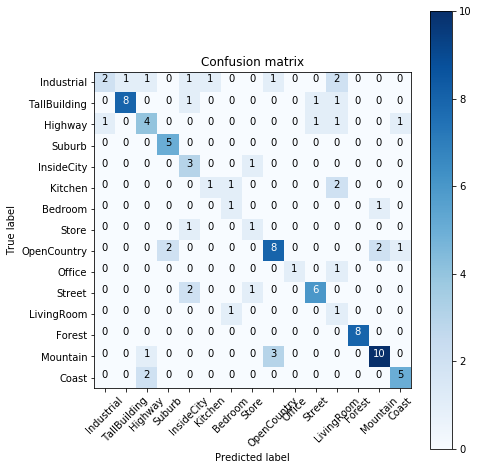

In [33]:
# fix seed to reproduce
np.random.seed(2)
torch.manual_seed(2)

plt.rcParams["figure.figsize"] = (7,7) # figure size
# evaluate accuracy and plot confusion matrix
evaluateNN(net, X_test, y_test)